In [1]:
import pandas as pd
import numpy as np
import os
import json
import jsonlines
import plotly.graph_objects as go
import soccerfield
%load_ext autoreload
%autoreload 2

In [2]:
def load_json_file(file_path):
    with open(file_path, 'r') as file:
        data = json.load(file)
    return data

In [3]:
def load_jsonl_file(file_path):
    with jsonlines.open(file_path, 'r') as file:
        data = [line for line in file if line['timestamp'] is not None]
    return data

In [4]:
match_id = 1133203

In [5]:
file_path = f'data/FA/tracking/{match_id}.jsonl'

In [6]:
data = load_jsonl_file(file_path)

In [7]:
file_path = f'data/FA/match/{match_id}.json'

In [8]:
match_data = load_json_file(file_path)

In [20]:
player_map = {player['id']: f"{player['first_name']} {player['last_name']}" for player in match_data['players']}

In [21]:
player_map

{68743: 'Katie Zelem',
 68680: 'Danielle Turner',
 68719: 'Anna Patten',
 68661: 'Lucy Parker',
 62646: 'Ebony Salmon',
 22608: 'Nikita Parris',
 68697: 'Maya Le Tissier',
 62411: 'Ella Toone',
 63767: 'Millie Turner',
 64066: 'Kirsty Hanson',
 22735: 'Adriana Leon',
 62505: 'Hinata Miyazawa',
 22624: 'Lucy Staniforth',
 63765: 'Jordan Nobbs',
 68681: 'Gabrielle George',
 68672: 'Sarah Emma Mayling',
 22618: 'Rachel Daly',
 22628: 'Rachel Corsie',
 68734: 'Rachel Williams',
 68744: 'Leah Galton',
 57096: 'Hannah Blundell',
 151604: 'Phallon Tullis-Joyce',
 63932: 'Lisa Fjeldstad Naalsund',
 22724: 'Jayde Yuk Fun Riviere',
 68199: 'Irene  Guerrero Sanmartín',
 64156: 'Gemma Jayne Evans',
 153392: 'Evie Rabjohn',
 22622: 'Mary Earps',
 22457: 'Lucía García Córdoba',
 64166: 'Hayley Ladd',
 22555: ' Geyse',
 62772: 'Simone Magill',
 68749: 'Olivia McLoughlin',
 68670: 'Mayumi Pacheco',
 424697: 'Georgia Mullett',
 59723: 'Anna Jessica Leat',
 63552: 'Daphne van Domselaar',
 64130: 'Alisha

In [9]:
home_id = match_data['home_team']['id']
away_id = match_data['away_team']['id']

In [10]:
home_p_ids = [p['id'] for p in match_data['players'] if p['team_id'] == home_id]
away_p_ids = [p['id'] for p in match_data['players'] if p['team_id'] == away_id]

In [11]:
def map_player_ids(player_list, home_p_ids, away_p_ids):
    return ['H' if player['player_id'] in home_p_ids else 'A' if player['player_id'] in away_p_ids else None for player in player_list]

In [26]:
def map_player_names(player_list):
    return [player_map[player['player_id']] for player in player_list]

In [55]:
event_frame = 107

In [56]:
frames = [f for f in data if f['frame']>= event_frame-10 and f['frame']<=event_frame+20]

In [57]:
frames_df = pd.DataFrame(frames)

In [58]:
frames_df['ball_x'] = frames_df['ball_data'].apply(lambda x: x['x'])
frames_df['ball_y'] = frames_df['ball_data'].apply(lambda x: x['y'])
frames_df['p_x'] = frames_df['player_data'].apply(lambda x: [p['x'] for p in x])
frames_df['p_y'] = frames_df['player_data'].apply(lambda x: [p['y'] for p in x])
frames_df['team'] = frames_df['player_data'].apply(lambda players: map_player_ids(players, home_p_ids, away_p_ids))
frames_df['name'] = frames_df['player_data'].apply(lambda players: map_player_names(players))

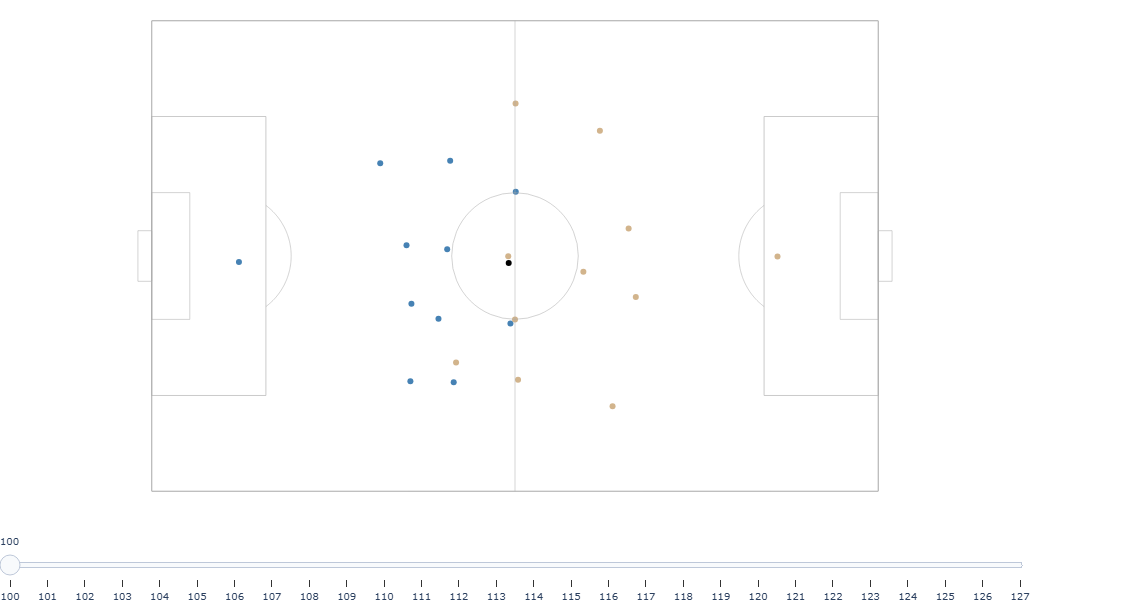

In [59]:
color_map = {'H': 'steelblue', 'A': 'tan'}
field_layout = soccerfield.get_layout(105, 68)

fig = go.Figure(layout=field_layout)
fig.update_layout(width=920, height=600, paper_bgcolor="rgba(0,0,0,0)", plot_bgcolor='rgba(0,0,0,0)',
                  margin=dict(l=0, r=100, t=0, b=0),
                  xaxis=dict(showgrid=False, zeroline=False), yaxis=dict(showgrid=False, zeroline=False),
                  legend=dict(xanchor="left", x=1, y=0.85,
                              font = dict(family = "Roboto, sans-serif", size = 14))
                  )

fig.update_layout(dragmode= False)


for idx, row in frames_df.iterrows():        
    colors = [color_map[value] for value in row['team']]
    fig.add_trace(
        go.Scatter(
            visible=False,
            x=row['p_x'], y=row['p_y'], mode='markers', marker=dict(color=colors), showlegend = False,
            hovertext = row['name']
        ))
    fig.add_trace(
        go.Scatter(
            visible=False,
            x=[row['ball_x']], y=[row['ball_y']], mode='markers', marker=dict(color='black'), showlegend = False   
        ))
fig.data[0].visible = True
fig.data[1].visible = True

visibility = []
fame_number = frames_df['frame'].to_list()
for i in range(len(frames)):
    frame_viz = dict(
        method="update",
        args=[{"visible": [False] * len(fig.data)}],
        label = fame_number[i]
    )
    frame_viz["args"][0]["visible"][i*2] = True
    frame_viz["args"][0]["visible"][i*2+1] = True
    visibility.append(frame_viz)
    
sliders = [dict(
        active=0, steps=visibility, font=dict(size=10)
    )]

fig.update_layout(
        sliders=sliders
    )